In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



#Data Cleaning and Feture Engineering



In [3]:
train=pd.read_csv("/content/gdrive/MyDrive/NYC taxi duration prediction/train.csv")

In [4]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [5]:
train.shape

(1458644, 11)

In [6]:
train["pickup_weekday"]=pd.to_datetime(train.pickup_datetime).dt.weekday
train["pickup_hour"]=pd.to_datetime(train.pickup_datetime).dt.hour

In [7]:
train.trip_duration.nlargest(10)

978383     3526282
924150     2227612
680594     2049578
355003     1939736
1234291      86392
295382       86391
73816        86390
59891        86387
1360439      86385
753765       86379
Name: trip_duration, dtype: int64

In [8]:
x=list(train.trip_duration.nlargest(4))
train=train[~train.trip_duration.isin(x)]

In [9]:
train.trip_duration.nlargest(10)

1234291    86392
295382     86391
73816      86390
59891      86387
1360439    86385
753765     86379
91717      86378
1221666    86378
66346      86377
1138915    86377
Name: trip_duration, dtype: int64

In [10]:
train=train[train.trip_duration>30]

In [11]:
train.reset_index(drop=True,inplace=True)

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1453750 entries, 0 to 1453749
Data columns (total 13 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1453750 non-null  object 
 1   vendor_id           1453750 non-null  int64  
 2   pickup_datetime     1453750 non-null  object 
 3   dropoff_datetime    1453750 non-null  object 
 4   passenger_count     1453750 non-null  int64  
 5   pickup_longitude    1453750 non-null  float64
 6   pickup_latitude     1453750 non-null  float64
 7   dropoff_longitude   1453750 non-null  float64
 8   dropoff_latitude    1453750 non-null  float64
 9   store_and_fwd_flag  1453750 non-null  object 
 10  trip_duration       1453750 non-null  int64  
 11  pickup_weekday      1453750 non-null  int64  
 12  pickup_hour         1453750 non-null  int64  
dtypes: float64(4), int64(5), object(4)
memory usage: 144.2+ MB


In [13]:
def haversine_distance(lat1, lon1, lat2, lon2):
        r = 6371
        phi1 = np.radians(lat1)
        phi2 = np.radians(lat2)
        delta_phi = np.radians(lat2-lat1)
        delta_lambda = np.radians(lon2-lon1)
        a = np.sin(delta_phi / 2)**2 + np.cos(phi1) * np.cos(phi2) *   np.sin(delta_lambda / 2)**2
        res = r * (2 * np.arctan2(np.sqrt(a), np.sqrt(1-a)))
        return res

In [14]:
train["dist_bet_locat"]=haversine_distance(train.pickup_latitude,train.pickup_longitude,
                                           train.dropoff_latitude,train.dropoff_longitude)

In [15]:
train=train[(train.pickup_longitude>=(-120)) & (train.pickup_latitude>=34)&(train.pickup_latitude<=45)]
train=train[(train.dropoff_longitude>-120) & (train.dropoff_latitude>34)&(train.dropoff_latitude<=45)]

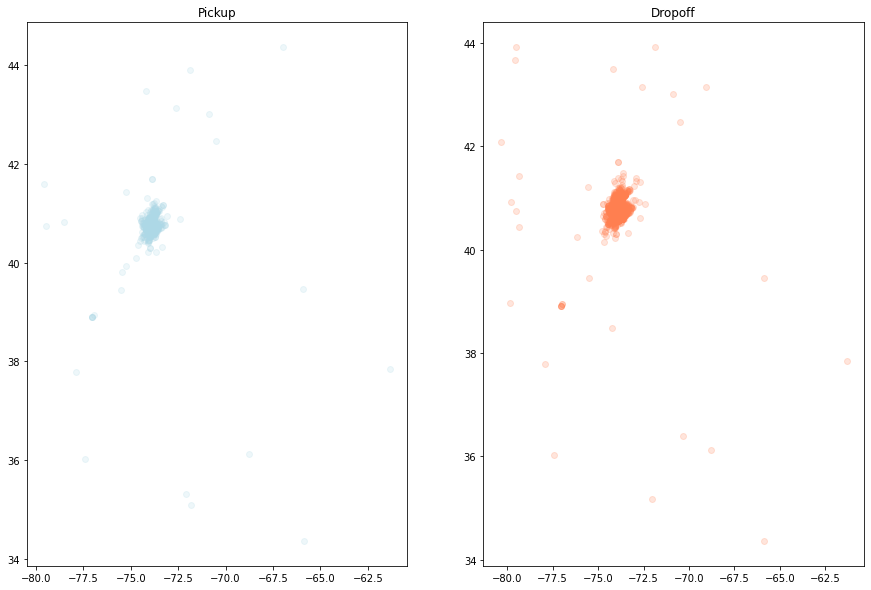

In [16]:
fig,ax=plt.subplots(1,2,figsize=(15,10))
ax[0].scatter(train["pickup_longitude"],
              train["pickup_latitude"],c='lightblue',alpha = 0.2)
ax[0].set_title('Pickup')
ax[1].scatter(train["dropoff_longitude"],
              train["dropoff_latitude"],c='coral',alpha = 0.2)
ax[1].set_title('Dropoff')
plt.show()

In [17]:
def outlier_treatment(datacolumn):

    sorted(datacolumn)
    Q1,Q3 = np.percentile(datacolumn , [25,75])
    IQR = Q3-Q1
    lower_range = Q1 - (1.5 * IQR)
    upper_range = Q3 + (1.5* IQR)
    return lower_range,upper_range

In [18]:
lower_range,upper_range=outlier_treatment(train['trip_duration'])
lower_range,upper_range
lower_range=round(float(lower_range))
upper_range=round(float(upper_range))

In [19]:
lower_range,upper_range

(-618, 2094)

In [20]:
lower_range_dist,upper_range_dist=outlier_treatment(train.dist_bet_locat)
lower_range_dist,upper_range_dist
lower_range_dist=round(float(lower_range_dist))
upper_range_dist=round(float(upper_range_dist))

In [21]:
lower_range_dist,upper_range_dist

(-3, 8)

In [22]:
train=train[(train.trip_duration<=upper_range)&(train.trip_duration>=lower_range)]
train=train[(train.dist_bet_locat<=upper_range_dist)&(train.dist_bet_locat>=lower_range_dist)]

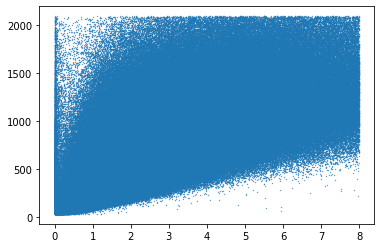

In [23]:
plt.scatter(train.dist_bet_locat,train.trip_duration,s=0.1)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


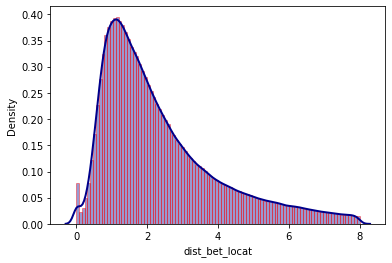

In [24]:
sns.distplot(train["dist_bet_locat"], hist=True, kde=True, 
             bins=100, color = 'darkblue', 
             hist_kws={'edgecolor':'red'},
             kde_kws={'linewidth': 2})

In [25]:
def bearing(pickup_lat, pickup_long, dropoff_lat, dropoff_long):
    '''Calculate the direction of travel in degrees'''
    pickup_lat_rads = np.radians(pickup_lat)
    pickup_long_rads = np.radians(pickup_long)
    dropoff_lat_rads = np.radians(dropoff_lat)
    dropoff_long_rads = np.radians(dropoff_long)
    long_delta_rads = np.radians(dropoff_long_rads - pickup_long_rads)
    
    y = np.sin(long_delta_rads) * np.cos(dropoff_lat_rads)
    x = (np.cos(pickup_lat_rads) * 
         np.sin(dropoff_lat_rads) - 
         np.sin(pickup_lat_rads) * 
         np.cos(dropoff_lat_rads) * 
         np.cos(long_delta_rads))
    
    return np.degrees(np.arctan2(y, x))

In [26]:
train['bearing'] = bearing(train.pickup_latitude,
                                  train.pickup_longitude,
                                  train.dropoff_latitude,
                                  train.dropoff_longitude)

In [27]:
train["speed"]=(train.dist_bet_locat/train.trip_duration)*3600

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


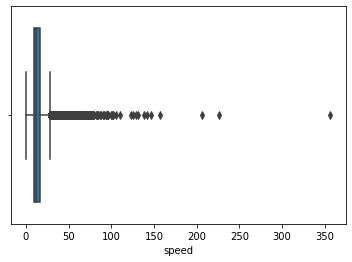

In [28]:
sns.boxplot(train['speed'])

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


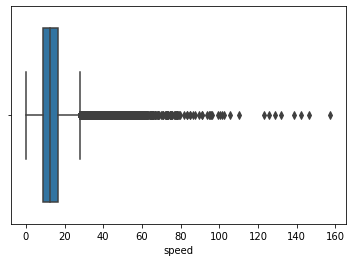

In [29]:
train=train[train.speed<=200]
sns.boxplot(train['speed'])

In [30]:
train.shape

(1298408, 16)

In [31]:
train.reset_index(drop=True,inplace=True)

In [32]:
from pandas.tseries.holiday import USFederalHolidayCalendar
calendar = USFederalHolidayCalendar()
holidays = calendar.holidays()
train['pickup_is_weekend'] = train.pickup_weekday.map(lambda x: 1 if x >= 5 else 0)
train['pickup_holiday'] = pd.to_datetime(pd.to_datetime(train.pickup_datetime).dt.date).isin(holidays)
train['pickup_holiday'] = train.pickup_holiday.map(lambda x: 1 if x == True else 0)

In [33]:
train['no_passengers'] = train.passenger_count.map(lambda x: 1 if x == 0 else 0)
train['one_passenger'] = train.passenger_count.map(lambda x: 1 if x == 1 else 0)
train['few_passengers'] = train.passenger_count.map(lambda x: 1 if x > 1 and x <= 4 else 0)
train['many_passengers'] = train.passenger_count.map(lambda x: 1 if x >= 5 else 0)

In [34]:
train.store_and_fwd_flag =train.store_and_fwd_flag.map(lambda x: 1 if x == 'Y' else 0)

In [35]:
def group_hour(hours):
  if ( hours>=0) & (hours<6):
    return "midnight"
  elif (hours>=6) & (hours<11):
    return "morning"
  elif (hours>=11) & (hours<14):
    return "afternoon"
  elif( hours>=14) & (hours<18):
    return "evening"
  else :
    return "night"   

In [41]:
#group_hour_list=[group_hour(i) for i in train.pickup_hour]
#train["group_hour"]=group_hour_list
train["group_hour"]=list(map(group_hour,train.pickup_hour))

In [42]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_weekday,pickup_hour,dist_bet_locat,bearing,speed,pickup_is_weekend,pickup_holiday,no_passengers,one_passenger,few_passengers,many_passengers,group_hour
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,0,455,0,17,1.498521,174.333195,11.856428,0,0,0,1,0,0,evening
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,0,663,6,0,1.805507,-178.051506,9.803659,1,0,0,1,0,0,midnight
2,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,0,429,2,19,1.485498,-179.872566,12.465721,0,0,0,1,0,0,night
3,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,0,435,5,13,1.188588,179.990812,9.836594,1,0,0,1,0,0,afternoon
4,id0801584,2,2016-01-30 22:01:40,2016-01-30 22:09:03,6,-73.982857,40.742195,-73.992081,40.749184,0,443,5,22,1.098942,-0.999797,8.930458,1,0,0,0,0,1,night


In [43]:
feature=["group_hour","pickup_weekday"]
for a,i in enumerate(feature):
  dummy_feature = pd.get_dummies(train[i],drop_first=True)
  if a==0:
    dummy_features=dummy_feature
  else:
    dummy_features=pd.concat([dummy_features,dummy_feature],axis=1)
    
    


In [44]:
dummy_feature = pd.get_dummies(train["pickup_weekday"],drop_first=True)

In [45]:
train=pd.concat([train,dummy_features],axis=1)

In [46]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_weekday,pickup_hour,dist_bet_locat,bearing,speed,pickup_is_weekend,pickup_holiday,no_passengers,one_passenger,few_passengers,many_passengers,group_hour,evening,midnight,morning,night,1,2,3,4,5,6
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,0,455,0,17,1.498521,174.333195,11.856428,0,0,0,1,0,0,evening,1,0,0,0,0,0,0,0,0,0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,0,663,6,0,1.805507,-178.051506,9.803659,1,0,0,1,0,0,midnight,0,1,0,0,0,0,0,0,0,1
2,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,0,429,2,19,1.485498,-179.872566,12.465721,0,0,0,1,0,0,night,0,0,0,1,0,1,0,0,0,0
3,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,0,435,5,13,1.188588,179.990812,9.836594,1,0,0,1,0,0,afternoon,0,0,0,0,0,0,0,0,1,0
4,id0801584,2,2016-01-30 22:01:40,2016-01-30 22:09:03,6,-73.982857,40.742195,-73.992081,40.749184,0,443,5,22,1.098942,-0.999797,8.930458,1,0,0,0,0,1,night,0,0,0,1,0,0,0,0,1,0


In [47]:
train.columns

Index([                'id',          'vendor_id',    'pickup_datetime',
         'dropoff_datetime',    'passenger_count',   'pickup_longitude',
          'pickup_latitude',  'dropoff_longitude',   'dropoff_latitude',
       'store_and_fwd_flag',      'trip_duration',     'pickup_weekday',
              'pickup_hour',     'dist_bet_locat',            'bearing',
                    'speed',  'pickup_is_weekend',     'pickup_holiday',
            'no_passengers',      'one_passenger',     'few_passengers',
          'many_passengers',         'group_hour',            'evening',
                 'midnight',            'morning',              'night',
                          1,                    2,                    3,
                          4,                    5,                    6],
      dtype='object')

In [48]:
drop_feature=['id','pickup_datetime','dropoff_datetime','pickup_hour','pickup_weekday','group_hour',"passenger_count"]
train.drop(drop_feature,axis=1,inplace=True)

In [49]:
train.head()

,vendor_id,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,dist_bet_locat,bearing,speed,pickup_is_weekend,pickup_holiday,no_passengers,one_passenger,few_passengers,many_passengers,evening,midnight,morning,night,1,2,3,4,5,6
0,2,-73.982155,40.767937,-73.964630,40.765602,0,455,1.498521,174.333195,11.856428,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
1,1,-73.980415,40.738564,-73.999481,40.731152,0,663,1.805507,-178.051506,9.803659,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1
2,2,-74.010040,40.719971,-74.012268,40.706718,0,429,1.485498,-179.872566,12.465721,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0
3,2,-73.973053,40.793209,-73.972923,40.782520,0,435,1.188588,179.990812,9.836594,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
4,2,-73.982857,40.742195,-73.992081,40.749184,0,443,1.098942,-0.999797,8.930458,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0


In [50]:
train.corr()

,vendor_id,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,dist_bet_locat,bearing,speed,pickup_is_weekend,pickup_holiday,no_passengers,one_passenger,few_passengers,many_passengers,evening,midnight,morning,night,1,2,3,4,5,6
vendor_id,1.000000,0.007894,0.008656,0.004787,0.006829,-0.074071,0.000728,-0.000791,-0.002944,-0.000969,0.002694,0.005569,-0.000862,-0.219681,0.048186,0.285464,-0.005021,-0.009764,0.000231,0.009627,0.001408,-0.001361,-0.001704,-0.000919,0.000413,0.003153
pickup_longitude,0.007894,1.000000,0.245824,0.782213,0.139645,0.001690,-0.028736,0.026019,-0.152826,0.078859,-0.018355,0.003723,0.000158,0.008625,-0.011932,0.003151,0.019609,-0.030529,0.035670,-0.033771,0.004929,0.003503,0.000730,0.002995,-0.017819,-0.005487
pickup_latitude,0.008656,0.245824,1.000000,0.111673,0.704855,-0.001529,-0.073831,-0.073756,-0.151633,0.027641,-0.046472,-0.001173,-0.000830,0.008940,-0.011806,0.002476,0.052507,-0.115426,0.057574,-0.047089,0.017261,0.015401,0.009474,0.002680,-0.033892,-0.025857
dropoff_longitude,0.004787,0.782213,0.111673,1.000000,0.236016,0.002588,0.015163,0.122725,0.223132,0.137312,-0.007302,0.004513,0.000242,0.005663,-0.008054,0.002381,-0.002556,0.047908,-0.010801,-0.006132,0.001714,0.001242,-0.002302,0.001548,-0.014129,0.005323
dropoff_latitude,0.006829,0.139645,0.704855,0.236016,1.000000,-0.002772,-0.109507,-0.064744,0.047892,0.082334,-0.036050,-0.001027,-0.000430,0.005787,-0.007932,0.002016,0.052778,-0.086244,0.031784,-0.034118,0.014545,0.012740,0.006563,0.000378,-0.029959,-0.016147
store_and_fwd_flag,-0.074071,0.001690,-0.001529,0.002588,-0.002772,1.000000,0.007229,0.006147,0.002428,-0.001848,-0.003366,0.000120,0.002656,0.015378,-0.002528,-0.021227,0.004535,-0.001264,-0.003782,-0.001293,0.000269,0.000558,0.001463,0.001163,-0.001183,-0.003230
trip_duration,0.000728,-0.028736,-0.073831,0.015163,-0.109507,0.007229,1.000000,0.686925,-0.028883,-0.241496,-0.060553,-0.038154,-0.002479,-0.019746,0.022245,0.000070,0.048151,-0.070095,-0.023604,-0.008686,0.017400,0.031794,0.039221,0.021130,-0.016121,-0.063591
dist_bet_locat,-0.000791,0.026019,-0.073756,0.122725,-0.064744,0.006147,0.686925,1.000000,-0.063792,0.413324,0.046821,0.006244,-0.002517,-0.011141,0.013128,-0.000772,-0.063268,0.109455,-0.035666,0.051983,-0.016358,-0.015669,-0.012618,-0.009426,0.022550,0.038417
bearing,-0.002944,-0.152826,-0.151633,0.223132,0.047892,0.002428,-0.028883,-0.063792,1.000000,-0.089512,0.010974,0.004190,0.000073,-0.000591,0.000657,0.000013,-0.022918,0.077916,-0.042215,0.028471,-0.003612,-0.003069,-0.003341,-0.001212,0.004680,0.009650
speed,-0.000969,0.078859,0.027641,0.137312,0.082334,-0.001848,-0.241496,0.413324,-0.089512,1.000000,0.127289,0.053749,-0.003498,0.013406,-0.014832,-0.000364,-0.134366,0.230979,0.000829,0.047829,-0.039285,-0.051546,-0.057385,-0.039960,0.043076,0.123878


In [51]:
x=train.drop('trip_duration',axis=1).values
y=train.trip_duration


In [52]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=train_test_split(x,y,test_size=0.30,random_state=0)

In [53]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [54]:
pipeline_lr=Pipeline([("scaler",StandardScaler()),
                     ("linear",LinearRegression())])


pipeline_decision=Pipeline([('decisi_model',DecisionTreeRegressor())])

pipeline_ensemble=Pipeline([('ensembl_model',RandomForestRegressor())])

In [55]:
pipeline=[pipeline_lr,pipeline_decision,pipeline_ensemble]

In [56]:
for pipe in pipeline:
  pipe.fit(X_train,y_train)



In [57]:
pipeline_dict={0:"linear_regression",1:"descision_tree",2:"random_forest"}

In [59]:
for a,model in enumerate(pipeline):
  print("reagressor model {} and model accuracy{}".format(pipeline_dict[a],model.score(X_test,y_test))) 


reagressor model linear_regression and model accuracy0.8090039712908276
reagressor model descision_tree and model accuracy0.9924451444567685
reagressor model random_forest and model accuracy0.9960501780085481


In [60]:
model_accuracy=0
for a,model in enumerate(pipeline):
  if model.score(X_test,y_test)>model_accuracy:
    model_accuracy=model.score(X_test,y_test)
    best_model=pipeline_dict[a]
print("best reagressor model {} and model accuracy{}".format(best_model,model_accuracy))    



best reagressor model random_forest and model accuracy0.9960501780085481


In [64]:
#we used descision tree because it give good reslut 
# we don't used random forest because it require more computational power and consume more time 
from sklearn.model_selection import cross_validate
score=cross_validate(pipeline[1],X_train,y_train,cv=5)

In [65]:
score['test_score'].mean()

0.9920519244501484

In [66]:
model=DecisionTreeRegressor()
model=model.fit(X_train,y_train)
model.score(X_test,y_test)

0.9924988593090923

In [68]:
y_pred=model.predict(X_test)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


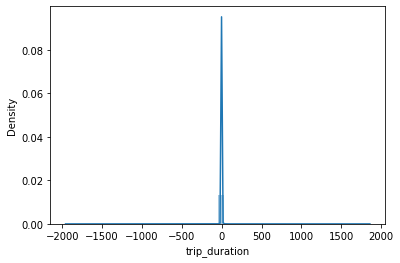

In [69]:
sns.distplot(y_test-y_pred)


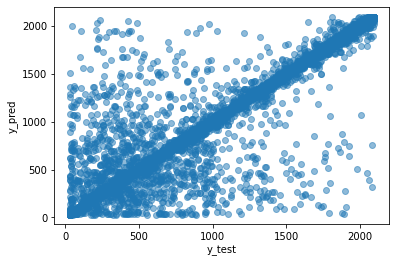

In [73]:
plt.scatter(y_test, y_pred, alpha = 0.5)
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.show()

In [71]:
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
############
metrics.r2_score(y_test, y_pred)

MAE: 3.509380276218178
MSE: 1243.2920918662055
RMSE: 35.2603473021212


0.9924988593090923

/usr/local/lib/python3.6/dist-packages/google/colab/_event_manager.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


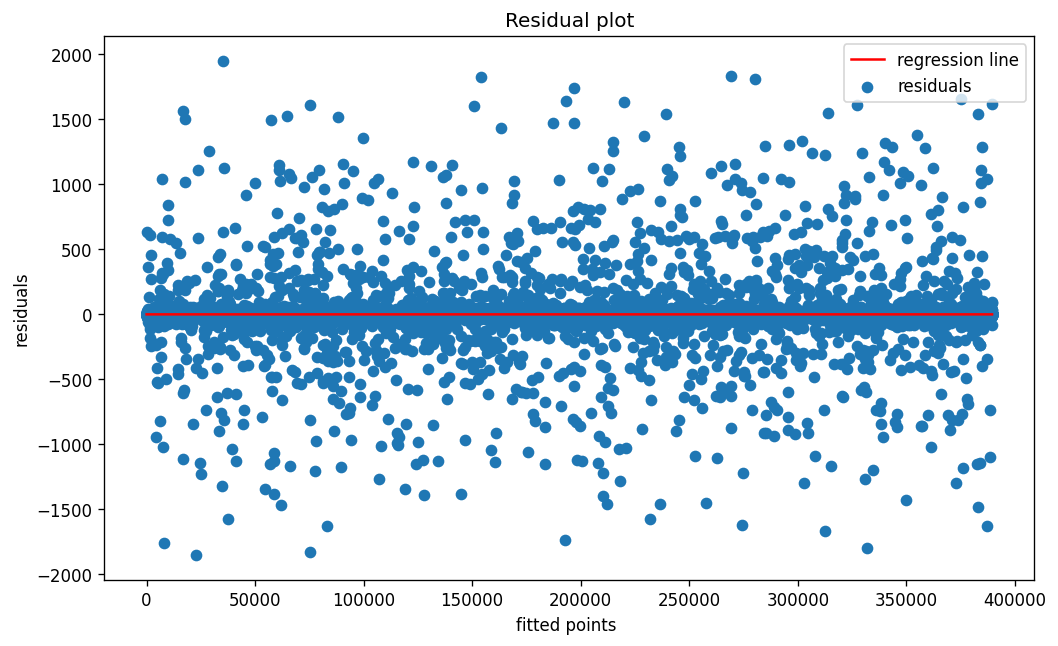

In [74]:
#residuals=y_pred-X_test[:]Heteroskedasticity
residuals=y_pred-y_test
plt.figure(figsize=(10, 6), dpi=120, facecolor='w', edgecolor='b')
f = range(0,len(X_test))
k = [0 for i in range(0,len(X_test))]
plt.scatter( f, residuals, label = 'residuals')
plt.plot( f, k , color = 'red', label = 'regression line' )
plt.xlabel('fitted points ')
plt.ylabel('residuals')
plt.title('Residual plot')
plt.legend()